# Problem 4 — Anomaly & Fraud Detection 

**Goal:** Detect unusual users and potential fraud from clickstream/transaction data.

**Approach (unsupervised):**
1) Load cleaned user-event data from S3  
2) Aggregate to **per-user features** (events, distinct items, distinct transactions)  
3) Train **Isolation Forest**  
4) Score users → flag anomalies (−1) vs normal (1)  
5) Summarize & visualize results for investigation

**Why unsupervised?** We don’t assume labeled fraud. The model isolates rare, extreme behavior that often corresponds to bots, abuse, or compromised accounts.


## Environment Setup

We install S3/Parquet helpers so Pandas can read data directly from **Amazon S3**:

- **`s3fs`**: file system interface for S3  
- **`pyarrow`**: Parquet reader/writer and columnar buffers


In [19]:
%pip install s3fs pyarrow


Note: you may need to restart the kernel to use updated packages.


## Connectivity & Schema Sanity Check

Before loading the full dataset, we read **one small Parquet file** from S3 to:

- verify credentials/paths  
- inspect the schema (columns like `visitorid`, `event`, `itemid`, `transactionid`, `event_time`)


In [20]:
import pandas as pd

# Try loading a SINGLE small Parquet file as a test:
df_test = pd.read_parquet('s3://ecommerce-user-behavior-2025/cleaned-data/events/event=transaction/part-00000-a0216035-1e87-478a-a2a2-2839d9feafaa.c000.snappy.parquet')
df_test.head()


,timestamp,visitorid,itemid,transactionid,event_time,session_id,event
0,1436719727267,5042,127634,15102,2015-07-12 16:48:47,5042_20150712,transaction
1,1437803832529,10023,51969,5602,2015-07-25 05:57:12,10023_20150725,transaction
2,1432397496727,12046,205663,14286,2015-05-23 16:11:36,12046_20150523,transaction
3,1435453041254,13455,48030,15606,2015-06-28 00:57:21,13455_20150628,transaction
4,1435209346502,24722,65992,12798,2015-06-25 05:15:46,24722_20150625,transaction


## 1) Data Loading

We read cleaned parquet files (Athena/Glue outputs) from S3.  
The `events` dataset contains per-interaction records:

- `visitorid` — user identifier  
- `event` — {view, addtocart, transaction}  
- `itemid`, `transactionid`, `timestamp` — item & time context

This notebook treats S3 as the data lake and reads directly with `pyarrow/s3fs`.


In [21]:
import pandas as pd

events_df = pd.read_parquet(
    's3://ecommerce-user-behavior-2025/cleaned-data/events/',
    engine='pyarrow'
)
category_tree_df = pd.read_parquet(
    's3://ecommerce-user-behavior-2025/cleaned-data/category_tree/',
    engine='pyarrow'
)
item_properties_df = pd.read_parquet(
    's3://ecommerce-user-behavior-2025/cleaned-data/item_properties/',
    engine='pyarrow'
)

events_df.head(), category_tree_df.head(), item_properties_df.head()


(       timestamp  visitorid  itemid  transactionid          event_time  \
 0  1442290183293        177    6073            NaN 2015-09-15 04:09:43   
 1  1435035043096        420  357779            NaN 2015-06-23 04:50:43   
 2  1436902688954        964  430113            NaN 2015-07-14 19:38:08   
 3  1434567875793       2603  138613            NaN 2015-06-17 19:04:35   
 4  1432167899658       4101  170353            NaN 2015-05-21 00:24:59   
 
       session_id      event  
 0   177_20150915  addtocart  
 1   420_20150623  addtocart  
 2   964_20150714  addtocart  
 3  2603_20150617  addtocart  
 4  4101_20150521  addtocart  ,
    categoryid  parentid  is_root  level               path
 0         527      73.0    False      3    1202 > 73 > 527
 1         299      73.0    False      3    1202 > 73 > 299
 2         765    1229.0    False      2         1229 > 765
 3         749    1687.0    False      3  1335 > 1687 > 749
 4         433    1229.0    False      2         1229 > 433,


## 2) Quick EDA & Sanity Checks

Before modeling we verify:
- Event mix (how many views/add-to-carts/transactions)
- Unique users per event type
- Basic per-user activity distribution (very skewed → expect outliers)

This helps choose transformations (e.g., log1p) and informs the model contamination rate.


In [22]:
events_df['event'].value_counts()
events_df['visitorid'].value_counts().head(10)
events_df.groupby('event')['visitorid'].nunique()


/tmp/ipykernel_152/1354075472.py:3: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  events_df.groupby('event')['visitorid'].nunique()


event
addtocart        37722
transaction      11719
view           1404179
Name: visitorid, dtype: int64

## 3) Feature Engineering (Per-User Aggregates)

We collapse raw events into **one row per user** with behavior features:

- `total_events` — total interactions  
- `unique_transactions` — distinct `transactionid`s  
- `unique_items_interacted` — number of different items touched

> These compact features are robust, easy to compute at scale, and strongly indicative of abnormal behavior when extreme (e.g., too many events or too many distinct items in a short period).


In [23]:
user_stats = events_df.groupby('visitorid').agg({
    'event': 'count',
    'transactionid': 'nunique',
    'itemid': 'nunique'
}).rename(columns={'event': 'total_events', 'transactionid': 'unique_transactions'})



## Final Feature Engineering & Anomaly Model

We build richer per-user features:

- `click_events`, `cart_events`, `transaction_events`  
- `unique_items` — number of distinct items touched  
- `active_days` — number of calendar days the user was active  
- **Ratios**: `cart_to_click_ratio`, `transaction_to_click_ratio`

These features capture *volume*, *diversity*, *recency cadence*, and *conversion behavior*.

**Model:** We train **Isolation Forest** (unsupervised) on the numeric features.  
It flags atypical users with `anomaly_score`:
- `1` = normal behavior
- `-1` = anomaly (rare/extreme activity patterns)

This approach requires **no fraud labels** and is robust for skewed, heavy-tailed behavior.


In [24]:
from sklearn.ensemble import IsolationForest

features = user_stats.fillna(0)
model = IsolationForest(contamination=0.01, random_state=42)
user_stats['anomaly_score'] = model.fit_predict(features)


<Axes: xlabel='anomaly_score'>

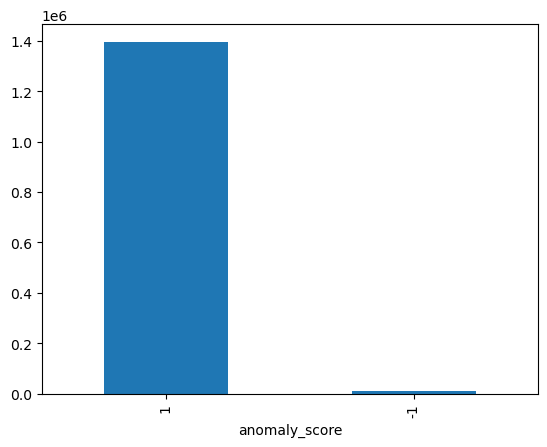

In [25]:
import matplotlib.pyplot as plt
user_stats['anomaly_score'].value_counts().plot(kind='bar')


<Axes: xlabel='anomaly_score', ylabel='total_events'>

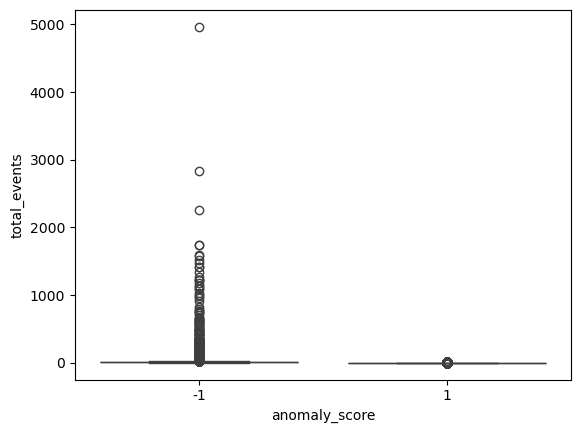

In [26]:
import seaborn as sns
sns.boxplot(data=user_stats, x='anomaly_score', y='total_events')


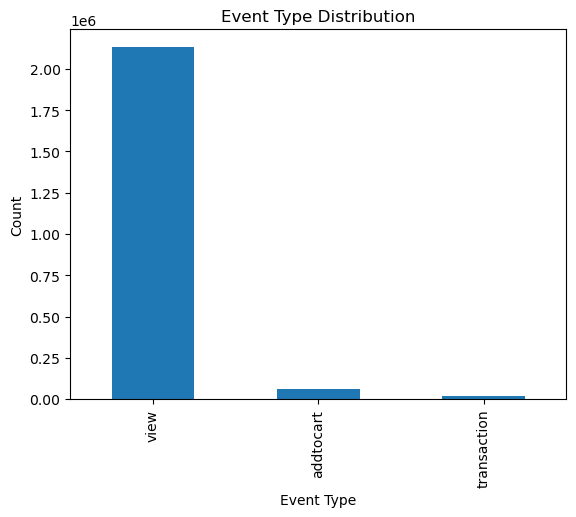

In [27]:
events_df['event'].value_counts().plot(kind='bar', title='Event Type Distribution')
plt.xlabel('Event Type')
plt.ylabel('Count')
plt.show()


/tmp/ipykernel_152/3566973161.py:1: FutureWarning: The default of observed=False is deprecated and will be changed to True in a future version of pandas. Pass observed=False to retain current behavior or observed=True to adopt the future default and silence this warning.
  event_visitor_counts = events_df.groupby('event')['visitorid'].nunique()


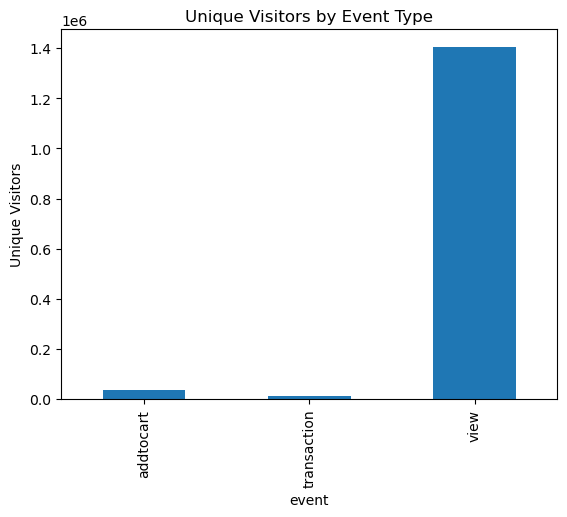

In [28]:
event_visitor_counts = events_df.groupby('event')['visitorid'].nunique()
event_visitor_counts.plot(kind='bar', title='Unique Visitors by Event Type')
plt.ylabel('Unique Visitors')
plt.show()


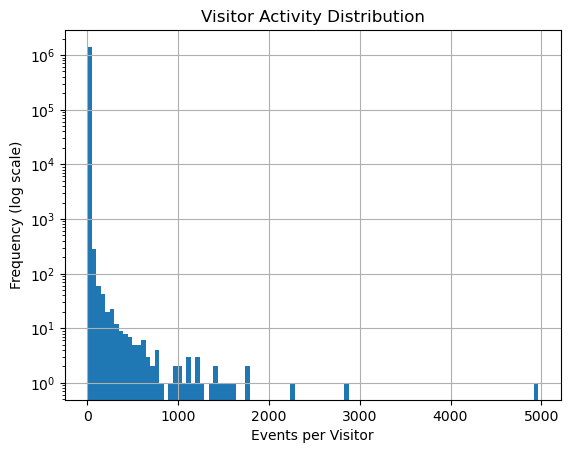

In [29]:
visitor_activity = events_df['visitorid'].value_counts()
visitor_activity.hist(bins=100, log=True)
plt.title("Visitor Activity Distribution")
plt.xlabel("Events per Visitor")
plt.ylabel("Frequency (log scale)")
plt.show()


In [30]:
user_stats = (
    events_df
    .groupby('visitorid')
    .agg(
        total_events=('event', 'count'),
        click_events=('event', lambda x: (x == 'click').sum()),
        cart_events=('event', lambda x: (x == 'addtocart').sum()),
        transaction_events=('event', lambda x: (x == 'transaction').sum()),
        unique_items=('itemid', pd.Series.nunique),
        active_days=('event_time', lambda x: x.dt.date.nunique())
    )
    .reset_index()
)
user_stats['cart_to_click_ratio'] = user_stats['cart_events'] / user_stats['click_events'].replace(0, 1)
user_stats['transaction_to_click_ratio'] = user_stats['transaction_events'] / user_stats['click_events'].replace(0, 1)
user_stats.head()


,visitorid,total_events,click_events,cart_events,transaction_events,unique_items,active_days,cart_to_click_ratio,transaction_to_click_ratio
0,0,3,0,0,0,3,1,0.0,0.0
1,1,1,0,0,0,1,1,0.0,0.0
2,2,4,0,0,0,4,1,0.0,0.0
3,3,1,0,0,0,1,1,0.0,0.0
4,4,1,0,0,0,1,1,0.0,0.0


<class 'pandas.core.frame.DataFrame'>
RangeIndex: 2215422 entries, 0 to 2215421
Data columns (total 7 columns):
 #   Column         Dtype         
---  ------         -----         
 0   timestamp      int64         
 1   visitorid      int32         
 2   itemid         int32         
 3   transactionid  float64       
 4   event_time     datetime64[ns]
 5   session_id     object        
 6   event          category      
dtypes: category(1), datetime64[ns](1), float64(1), int32(2), int64(1), object(1)
memory usage: 86.6+ MB
None
          timestamp     visitorid        itemid  transactionid  \
count  2.215422e+06  2.215422e+06  2.215422e+06   21270.000000   
mean   1.436443e+12  7.019576e+05  2.346982e+05    8838.398213   
min    1.430622e+12  0.000000e+00  3.000000e+00       0.000000   
25%    1.433491e+12  3.505660e+05  1.177670e+05    4413.250000   
50%    1.436482e+12  7.022790e+05  2.355980e+05    8845.000000   
75%    1.439240e+12  1.052988e+06  3.505250e+05   13245.750000   
m

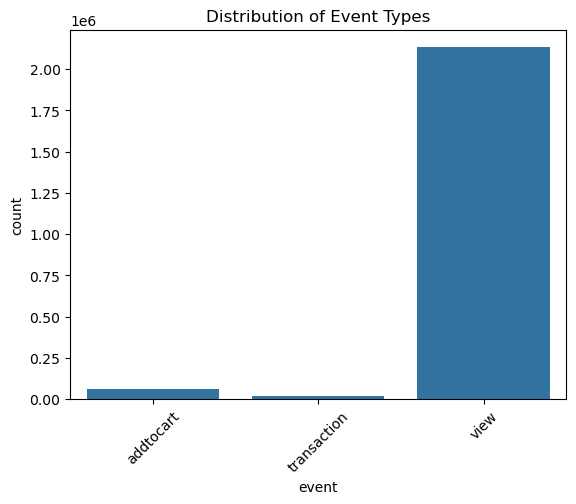

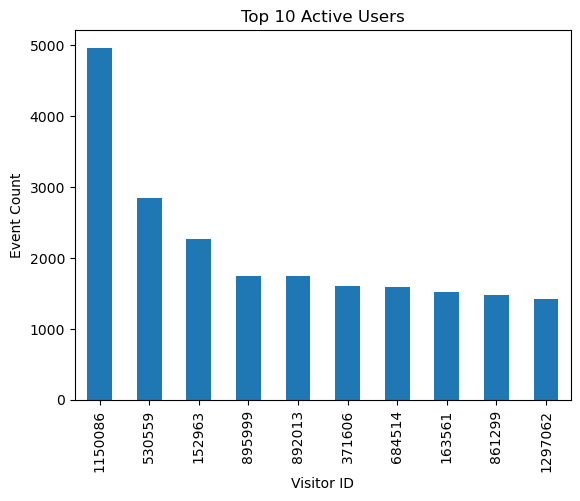

In [31]:
# Summary stats and missing values
print(events_df.info())
print(events_df.describe())
print(events_df.isnull().sum())

# Event distribution
import seaborn as sns
import matplotlib.pyplot as plt

sns.countplot(data=events_df, x='event')
plt.title("Distribution of Event Types")
plt.xticks(rotation=45)
plt.show()

# Top users by number of actions
top_users = events_df['visitorid'].value_counts().head(10)
top_users.plot(kind='bar', title='Top 10 Active Users')
plt.xlabel('Visitor ID')
plt.ylabel('Event Count')
plt.show()


In [32]:
# Create a user-level dataframe
user_stats = events_df.groupby('visitorid').agg({
    'event': 'count',
    'transactionid': pd.Series.nunique,
    'itemid': pd.Series.nunique
}).rename(columns={
    'event': 'total_events',
    'transactionid': 'unique_transactions',
    'itemid': 'unique_items_interacted'
})

# Fill any missing values
user_stats = user_stats.fillna(0)


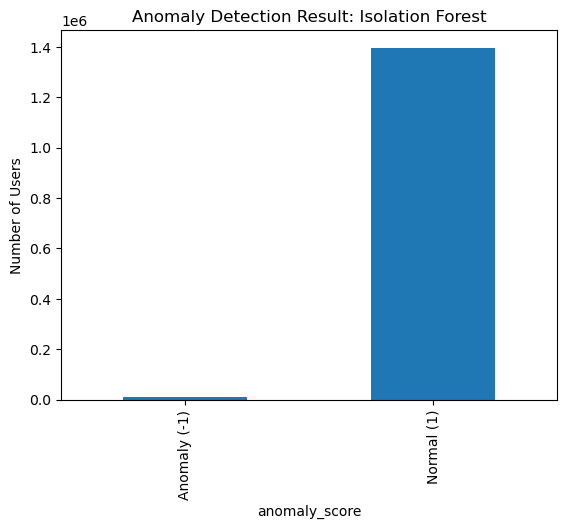

,total_events,unique_transactions,unique_items_interacted,anomaly_score
visitorid,,,,
1150086,4964,478,3814,-1
530559,2837,215,2209,-1
152963,2265,266,1622,-1
895999,1744,44,1641,-1
892013,1739,0,1738,-1
...,...,...,...,...
125769,5,2,3,-1
154217,5,2,3,-1
163083,5,2,3,-1


In [36]:
# Features for the model
features = user_stats[['total_events', 'unique_transactions', 'unique_items_interacted']].copy()

# Isolation Forest (robust, no scaling required)
from sklearn.ensemble import IsolationForest

iforest = IsolationForest(
    n_estimators=200,
    contamination=0.01,   # ~1% expected anomalies; adjust if needed
    random_state=42
)

user_stats = user_stats.copy()  # avoid SettingWithCopy warnings
user_stats['anomaly_score'] = iforest.fit_predict(features)   # -1 = anomaly, 1 = normal

# Quick distribution plot
user_stats['anomaly_score'].value_counts().sort_index().plot(kind='bar')
plt.title("Anomaly Detection Result: Isolation Forest")
plt.xticks(ticks=[0,1], labels=["Anomaly (-1)", "Normal (1)"])
plt.ylabel("Number of Users")
plt.show()

# Inspect top anomalies
anomalies = user_stats[user_stats['anomaly_score'] == -1]
anomalies.sort_values(by='total_events', ascending=False)


## Conclusion & Next Steps

This notebook delivers a **proof of concept** for Problem 4:
- Aggregates raw interactions into **user-level features**
- Uses **Isolation Forest** to flag **unusual/suspicious** users
- Produces **actionable outputs** (counts, plots, and a review list)

**Next steps (if time permits):**
1. Add rate features (events/min), device/IP diversity, time-of-day ratios  
2. Retrain on rolling windows (7–30 days) to adapt to drift  
3. Export anomalies to S3 and visualize in Power BI  
4. (Future) Scale to Spark/EMR and integrate alerting
